<a href="https://colab.research.google.com/github/mateosuster/nlpPapers/blob/main/code/05_LDA_TopicModels_GENSIM_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencias

In [3]:
%%capture
!pip install pyLDAvis==2.1.2

import os
from google.colab import files
from gensim.test.utils import datapath

import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
from collections import Counter


from nltk import word_tokenize, sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim import corpora

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import os, re, operator, warnings
warnings.filterwarnings('ignore')  
%matplotlib inline

# LDA

In [15]:
### LDA TOPICS:
# params
Tipo_Datos_ = "sampleados"  ### INGRESE DATOS A UTILIZAR: ELIJA: "totales" O "sampleados".
Cant_Optima_Topics = 32     ### INGRESE CANT. OPTIMA DE TOPICOS (En principio: 19, 20, 26, ó 12). 

# data
from pandas.core.describe import describe_categorical_1d
data_Total = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/data_gender_abstract_year.csv")
data_Sampleada = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/data_clean.csv")

if Tipo_Datos_ == "sampleados":
  data = data_Sampleada
elif Tipo_Datos_ == "totales":
  data = data_Total

if Tipo_Datos_ == "sampleados":
  dataset = data.text.tolist()
elif Tipo_Datos_ == "totales":
  dataset = data.ABSTRACT
  dataset = dataset.tolist()

#cleaning
STOP_WORDS = stopwords.words("english")

def tokenize(x):
    return [word for word in word_tokenize(x) if word not in STOP_WORDS and word.isalpha() and len(word)>1]

if Tipo_Datos_ == "sampleados":
  texts = [word_tokenize(str(doc)) for doc in dataset]
elif Tipo_Datos_ == "totales":
  texts= [tokenize(str(doc).lower()) for doc in dataset]

#dictionaries
dictionary = corpora.Dictionary(texts)  #crea diccionario asinandole un indice numerico a cada palabra
dictionary.filter_extremes(no_below=10, no_above=0.5)  #filtra tokens q aparencen en menos de 10 documentos y en mas de la mitad de los documentos.

### doc2bow:
corpus = [dictionary.doc2bow(text) for text in texts] #el bow cuenta cantidad de apariciones de cada palabra del diccionario

#### SETEO DE SEMILLA:
semilla = 420
np.random.seed(semilla)

# LDA realizado con el doc2bow (bolsa de palabras comun)  (NO con TF-IDF):
ldamodel_optimo = LdaModel(corpus=corpus, num_topics=Cant_Optima_Topics, id2word=dictionary, iterations = 200, passes=10, random_state=semilla)

#### COHERENCIAS TOTALES DEL MODELO:
window_size_=10     # INGRESE COHERENCIA WINDOW_SIZE 
coherence_='c_npmi' # INGRESE METRICA DE COHERENCIA 
topn_=32            # INGRESE COHERENCIA TOP WORDS TO EVALUATE. 

ldatopics_optimo = [[word for word, prob in topic] for topicid, topic in ldamodel_optimo.show_topics(Cant_Optima_Topics,formatted=False)]
lda_coherence = CoherenceModel(topics=ldatopics_optimo, texts=texts, dictionary=dictionary, window_size=window_size_,coherence=coherence_,topn=topn_).get_coherence_per_topic()
df_lda = pd.DataFrame([range(Cant_Optima_Topics),lda_coherence,ldatopics_optimo],index=['topic_id','coherence','topic']).transpose()

Coherence_Total = (sum(lda_coherence))
Coherence_Media = (np.mean(lda_coherence))
Coherence_Media_Ponderada = Coherence_Media/ Coherence_Total 

print('Nro. Topics Optimo: %.2f ' % (Cant_Optima_Topics))
print('Coherencia Media: %.2f ' % (round(Coherence_Total,2)))
print('Coherencia Total: %.2f ' % (round(Coherence_Media,2)))
print('Coherencia Total: %.2f ' % (round(Coherence_Media_Ponderada,2)))
print(" ")



Nro. Topics Optimo: 32.00 
Coherencia Media: 1.59 
Coherencia Total: 0.05 
Coherencia Total: 0.03 
 


## Distribucion de los topicos por año

Para un documento en particular

In [16]:
new_text = dataset[0]

# transform held_out_text into the bag-of-words space
bow_vector = dictionary.doc2bow(word_tokenize(new_text))
lda_vector = ldamodel_optimo[bow_vector]
print(lda_vector) # imprime las probabilidades de cada topico

# print the document's single most prominent LDA topic (palabras mas frecuentes de topico mas probable )
print(ldamodel_optimo.print_topic(max(lda_vector, key=lambda item: item[1])[0]))

[(0, 0.024405118), (1, 0.04701794), (4, 0.029646266), (5, 0.4286555), (14, 0.0762502), (17, 0.032569427), (22, 0.18977624), (29, 0.07584596), (30, 0.08385417)]
0.064*"languages" + 0.033*"multilingual" + 0.032*"language" + 0.023*"data" + 0.020*"domain" + 0.016*"available" + 0.015*"transfer" + 0.015*"target" + 0.014*"english" + 0.013*"dataset"


Cargo todos los papers y corro el LDA sobre ellos y Aplico el mismo preprocesamiento


In [17]:
papers_text  = [tokenize(str(doc).lower()) for doc in data_Total.ABSTRACT]
papers_text_df = pd.DataFrame([' '.join(text) for text in papers_text], columns = ['text'])

papers_text_df

,text
0,work assumes languages structured semantic fra...
1,social media one significantdigital platforms ...
2,increasing interest modeling dynamics temporal...
3,language models encode linguistic proprieties ...
4,recent advances commonsense reasoning fueled a...
...,...
33414,parc dependency bank number features would see...
33415,paper presents tool assisting manual annotatio...
33416,huge amount available information web creates ...
33417,antidote rx un logiciel aide la daction grand ...


In [18]:
papers_text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33419 entries, 0 to 33418
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    33419 non-null  object
dtypes: object(1)
memory usage: 261.2+ KB


In [19]:
results = []

for text_i in papers_text_df.text:

  # transform held_out_text into the bag-of-words space
  bow_vector = dictionary.doc2bow(word_tokenize(str(text_i)))
  lda_vector_i = ldamodel_optimo[bow_vector]

  # converting to dict
  result = dict(lda_vector_i)
  results.append(result)

topics_dis = pd.DataFrame(results)
topics_dis['year'] = data_Total.YEAR 
topics_dis = topics_dis.melt(id_vars = 'year', var_name='topic', value_name='prob')
topics_dis

,year,topic,prob
0,1991,0,0.024387
1,1991,0,NaN
2,1991,0,NaN
3,1991,0,0.019685
4,1991,0,0.116596
...,...,...,...
1069403,2022,9,NaN
1069404,2022,9,NaN
1069405,2022,9,NaN
1069406,2022,9,0.768820


In [20]:
topics_dis_agg = topics_dis.groupby(['year', 'topic' ], as_index= False).agg(
    {'prob' : ['mean', 'median', 'std', 'count'] }
     )

topics_dis_agg.column = ['year', 'topic' , 'prob_mean', 'prob_median', 'std', 'count' ]
topics_dis_agg = topics_dis_agg.reset_index()
topics_dis_agg.columns

MultiIndex([('index',       ''),
            ( 'year',       ''),
            ('topic',       ''),
            ( 'prob',   'mean'),
            ( 'prob', 'median'),
            ( 'prob',    'std'),
            ( 'prob',  'count')],
           )

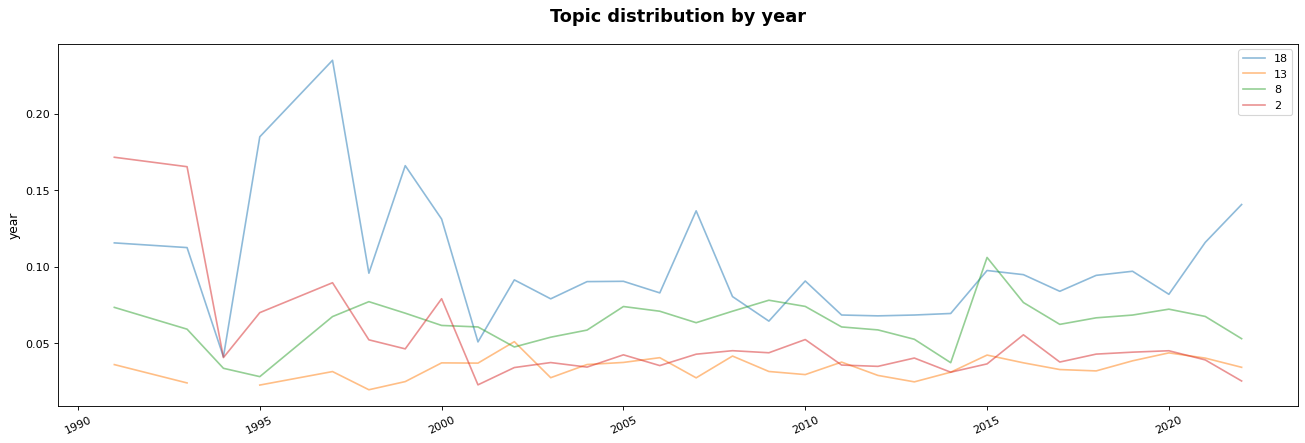

In [21]:
topics2viz = [18, 13, 8, 2]
viz_all = False

fig = plt.figure(figsize=(20, 6), dpi=80)
ax = fig.add_subplot(1, 1, 1)

plt.ylabel("year", fontsize=11)
plt.xticks(rotation=25)  # Rotates X-Axis Ticks by 45-degrees
# plt.xlabel('Days')

# displaying the title
plt.title(
    "Topic distribution by year", fontsize=16, fontweight="bold", pad=20
)
if viz_all == True:
  for i in topics_dis_agg.topic.unique():
      ax.plot(
          topics_dis_agg[topics_dis_agg["topic"] == i]["year"],
          topics_dis_agg[topics_dis_agg["topic"] == i]["prob", "median"],
          label=(i),
          # color="green",
          # color="#e41a1c",
          alpha=0.5,)
else: 
   for i in topics2viz:
      ax.plot(
          topics_dis_agg[topics_dis_agg["topic"] == i]["year"],
          topics_dis_agg[topics_dis_agg["topic"] == i]["prob", "median"],
          label=(i),
          # color="green",
          # color="#e41a1c",
          alpha=0.5,)


ax.legend()
plt.show()

# Visualizacion de distribucion de topicos

In [22]:
### GRAFICO DE TOPICOS DEL MODELO:
pyLDAvis.gensim.prepare(ldamodel_optimo, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16     0.208013  0.073254       1        1  17.806663
27     0.164168  0.146732       2        1   8.370206
1      0.144311 -0.029004       3        1   6.680221
18     0.093843 -0.138354       4        1   4.939915
19     0.154726  0.126873       5        1   4.353800
9     -0.257431  0.008990       6        1   4.285065
31     0.139496 -0.040773       7        1   4.260330
29     0.101111 -0.042590       8        1   4.129004
15     0.145521  0.208517       9        1   3.607523
22     0.089013 -0.172553      10        1   3.522236
5      0.141230 -0.058388      11        1   3.512679
28     0.103182 -0.230392      12        1   3.155627
7      0.096055 -0.032287      13        1   3.142445
4      0.066648 -0.074032      14        1   2.873094
8      0.061174 -0.079387      15        1   2.467965
17     0.077652  0.059263      16        1   2.460191
14     0.043993  0.144670      17        1   2.386889
11    -0.021537 -0.189846      18        1   1.884118
0      0.072514  0.119535      19        1   1.633448
24    -0.063363 -0.001597      20        1   1.604474
13    -0.109245 -0.044366      21        1   1.540226
2     -0.072026 -0.052624      22        1   1.533380
26    -0.035993  0.102254      23        1   1.462586
23    -0.047734  0.013618      24        1   1.347182
25    -0.052277  0.090711      25        1   1.244719
10    -0.074201 -0.093895      26        1   1.091903
3     -0.180196 -0.128735      27        1   1.002715
12    -0.085765  0.118195      28        1   0.965615
21    -0.162722  0.025626      29        1   0.941366
6     -0.272766  0.005826      30        1   0.656057
30    -0.258356  0.056171      31        1   0.588917
20    -0.209040  0.108585      32        1   0.549443, topic_info=             Term          Freq         Total Category  logprob  loglift
747   translation   6406.000000   6406.000000  Default  30.0000  30.0000
645          word   4798.000000   4798.000000  Default  29.0000  29.0000
3526           de   5693.000000   5693.000000  Default  28.0000  28.0000
208     knowledge   4756.000000   4756.000000  Default  27.0000  27.0000
209      language  12909.000000  12909.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
1061       robust    108.093831    647.331154  Topic32  -4.2751   3.4142
1938        noise     78.640832    447.224411  Topic32  -4.5932   3.4659
959     sensitive     68.748030    200.439843  Topic32  -4.7277   4.1340
635         input     71.756817   2161.628791  Topic32  -4.6849   1.7987
1591      example     62.534046    676.958214  Topic32  -4.8224   2.8221

[1891 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
893       1  0.250762  ability
893       2  0.010728  ability
893       3  0.122029  ability
893       5  0.008046  ability
893       8  0.327198  ability
...     ...       ...      ...
538      12  0.029017    years
538      13  0.033599    years
538      22  0.045817    years
538      24  0.015272    years
848      19  0.977135  youtube

[5115 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 28, 2, 19, 20, 10, 32, 30, 16, 23, 6, 29, 8, 5, 9, 18, 15, 12, 1, 25, 14, 3, 27, 24, 26, 11, 4, 13, 22, 7, 31, 21])

lambda 
* cercano a 1 muestra las palabras mas probables de cada topico
* cercano a 0 muestra las palabras mas especificas de cada topico (palabras raras, altamente probables en ese topico y poco probables en los otros). Son palabras muy asociados al topico y son palabras poco probables. Serian palabras diferencialmente mas probables para del topico (pueden ser palabras poco proablbes para el topico pq son poco proablabes en si)´


el grafico de la izquierda muestra los topicos distribuidos espacialmente segun si tienen palabras parecidas

# Dinamic LDA

In [26]:
from gensim.models import ldaseqmodel

#time slice
time_slice = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/time_slice.csv")
time_slice = time_slice.YEAR.to_list()


In [ ]:

ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=time_slice, 
                                 initialize = 'ldamodel', lda_model = ldamodel_optimo,
                                 num_topics=Cant_Optima_Topics
                                 )


# Save models

In [ ]:


# Save models to disk.
temp_file = datapath("/content/lda")
ldamodel_optimo.save(temp_file)

# Dowload models
path = "/content/"
dir_list = os.listdir(path)

for i in dir_list:
  if 'lsa' in i or 'lda' in i  :
    print('downloading')
    files.download(path + i)


downloading


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

downloading


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

downloading


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

downloading


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
topics_dis_agg.to_csv('topic_distribution_year.csv', index = False)
files.download('/content/topic_distribution_year.csv')

NameError: ignored